In [1]:
import numpy as np
import pandas as pd
import pysqlite3
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#sqlite connection
conn = pysqlite3.connect('kayzen.db')
%load_ext sql
%sql sqlite:///kayzen.db

### Other ipynb files
#### EDA.ipynb
* import csv files
* dropped duplicate 'Unique Id'
* df -> kayzen.db
    * imp
    * click
    * install
    * country

#### Categories.ipynb
* scraped pub categories using bs4
* df -> kayzen.db
    * Categories

### Optimizing Installs
#### Metrics:
* CTR (Click-through rate) = $\frac{clicks}{impressions}$
* CTI (Click to install) = $\frac{installs}{clicks}$
* IPM (Install per mille) = $\frac{installs}{1000 impressions}$

In [3]:
def get_metrics(from_df):
    """
    Creates and calculate new columns based on the metrics: CTR, CVR, IPM
    
    :param from_df: dataframe to be used
    :param from_df: dataframe
    """
    from_df['CTR'] = (from_df['clicks']/from_df['impressions'])*100
    from_df['CVR'] = (from_df['installs']/from_df['clicks'])*100
    from_df['IPM'] = (from_df['installs']*1000)/from_df['impressions']

Overall Perfomance per day

In [4]:
# Overall data

query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    Datetime,
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
)

SELECT
strftime('%m/%d/%Y',imp.Datetime) AS Date,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1
;
"""

overall = pd.read_sql_query(query,conn)
get_metrics(overall)

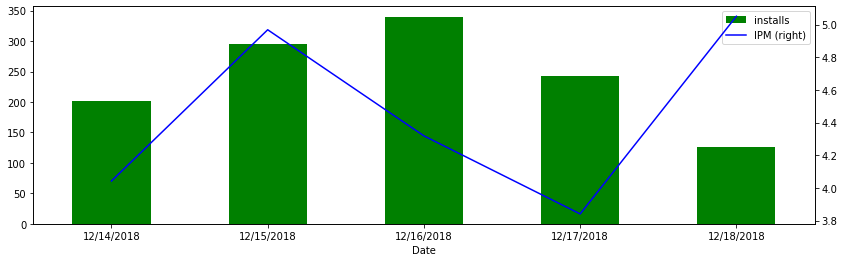

In [5]:
# Plotting Install Perfomance

ax = overall.plot(kind='bar', x='Date', y='installs',color='g',figsize=(14, 4))
ax2 = overall.plot(x='Date', y='IPM', secondary_y=True, ax=ax, color='b')

### Proposed Targeting Criteria

#### Targeting Criteria 1:
* **_'CAMPAIGN_TYPE'_** : [1,3]
* **_'CREATIVE_ID_1'_** : [90221, 23266, 21764]
* **_'OS_VERSION'_** : OS 81+ [81, 82, 83]

In [6]:
query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    Datetime,
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
)

SELECT
strftime('%m/%d/%Y',imp.Datetime) AS Date,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
WHERE imp.CAMPAIGN_TYPE in (1, 3)
AND imp.CREATIVE_ID_1 in (50253354, 50253358, 50253356)
AND imp.OS_VERSION in (81, 82, 83)
GROUP BY 1
;
"""

t_1 = pd.read_sql_query(query,conn)
get_metrics(t_1)

#### Plotting Overall vs Target Critetia 1

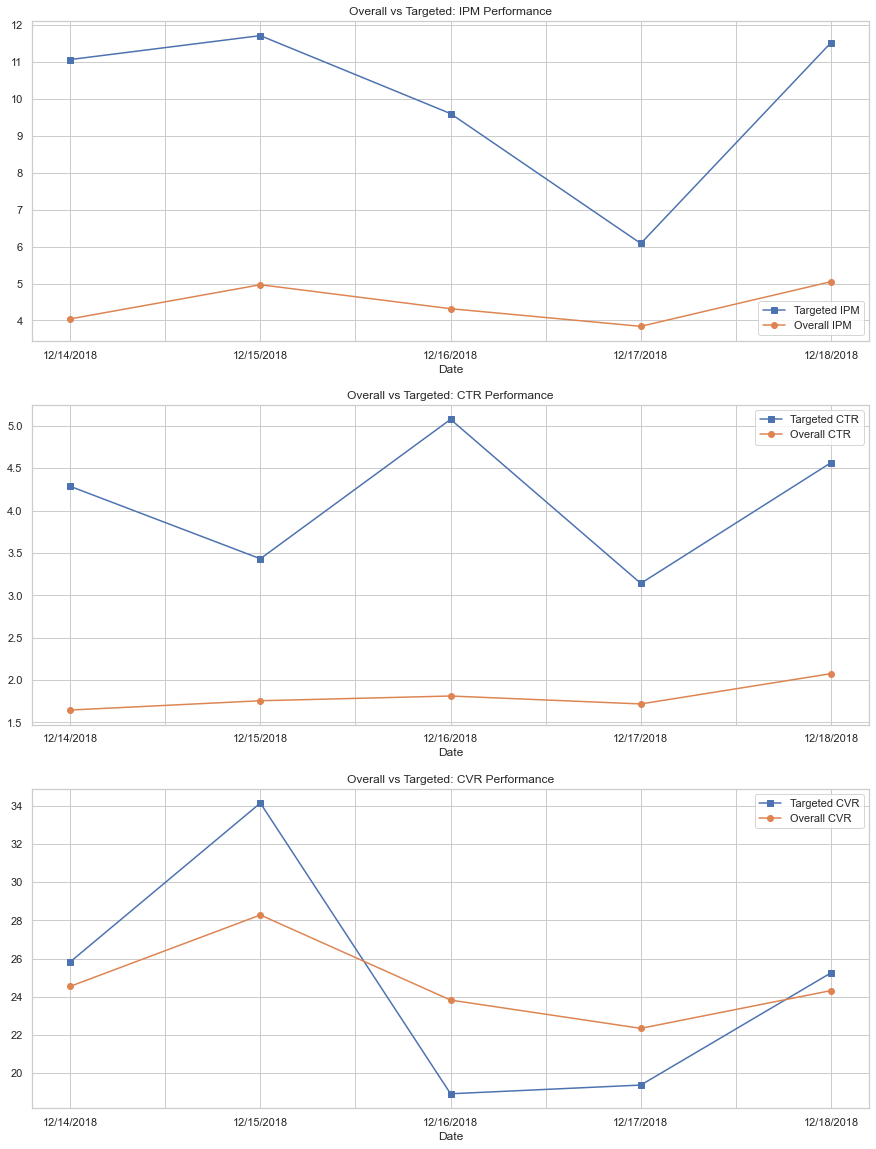

In [7]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,20))


ax = t_1.plot(x='Date', y='IPM', marker='s',title = 'Overall vs Targeted: IPM Performance',ax=axes[0])
ax2 = overall.plot(x='Date', y='IPM', ax=axes[0], marker='o')
ax.legend(["Targeted IPM", "Overall IPM"])


#CTR
ax = t_1.plot(x='Date', y='CTR', marker='s',title = 'Overall vs Targeted: CTR Performance',ax=axes[1])
ax2 = overall.plot(x='Date', y='CTR', ax=axes[1], marker='o')
ax.legend(["Targeted CTR", "Overall CTR"])


#CVR
ax = t_1.plot(x='Date', y='CVR', marker='s',title = 'Overall vs Targeted: CVR Performance',ax=axes[2])
ax2 = overall.plot(x='Date', y='CVR', ax=axes[2], marker='o')
ax.legend(["Targeted CVR", "Overall CVR"])


#### Targeting Criteria 1: Campaign Type

In [8]:
# Campaign Type

query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    Datetime,
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
)

SELECT
imp.CAMPAIGN_TYPE,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1
;
"""

c_type = pd.read_sql_query(query,conn)
get_metrics(c_type)
c_type

,CAMPAIGN_TYPE,impressions,clicks,installs,CTR,CVR,IPM
0,1,37989,310,149,0.816026,48.064516,3.922188
1,2,85260,1106,71,1.297209,6.419530,0.832747
2,3,152806,3478,985,2.276089,28.320874,6.446082


Exclude _'CAMPAIGN_TYPE 2'_ since we're generating significant impressions with low no. of installs delivered (IPM is undeperfoming). Reallocate budget to _'CAMPAIGN_TYPE 1'_ AND _'CAMPAIGN_TYPE 2'_

**Target Campaign Type: 1 and 3**

#### Targeting Criteria 1: Creative

In [9]:
# Creative

query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    Datetime,
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
)

SELECT
imp.CREATIVE_ID_1,
--imp.CREATIVE_ID_2,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1
ORDER BY 1,2,4 DESC;
"""
creative = pd.read_sql_query(query,conn)
get_metrics(creative)
creative.nlargest(15,'impressions').reset_index()

,index,CREATIVE_ID_1,impressions,clicks,installs,CTR,CVR,IPM
0,35,50253354,89367,2096,760,2.345385,36.259542,8.504258
1,38,50253358,22286,814,62,3.652517,7.616708,2.782016
2,37,50253356,20258,809,41,3.993484,5.067985,2.023892
3,22,50250933,19171,160,79,0.834594,49.375000,4.120807
4,30,50253086,18848,148,68,0.785229,45.945946,3.607810
5,36,50253355,16568,146,37,0.881217,25.342466,2.233221
6,39,50254303,14865,97,27,0.652540,27.835052,1.816347
7,41,50254305,14746,108,34,0.732402,31.481481,2.305710
8,34,50253353,14343,99,23,0.690232,23.232323,1.603570
9,40,50254304,13231,57,14,0.430806,24.561404,1.058121


Looking at the values sorted by max impressions, we can see that impressions after the 12th data point has < 1000 impressions. For good measure, we will exclude this from our targeting since we haven't delivered significant number of impressions to conclude that these 'CREATIVE_ID' performed well.

From these top impression generating creatives, we can now select a range of creatives that would generate up to par metrics from our original data.

#### Defining a new fucntion

In [10]:
# Transforming df > new_df: cumulative
def new_df(from_df, sort_by, n):
    """
    Creates a new cumulative dataframe sorted by a metric and calculates IPM,CVR and CTR threshold based on mean
    
    :param from_df: dataframe to be transformed
    :type from_df: dataframe
    :param sort_by: metric to be sorted by
    :type sort_by: 'string'
    :param n: limit of data output
    :type n: int
    :return: tuple df, IPM_threshold, CTR_threshold
    
    """
    #threshold
    CTR_threshold = (from_df['clicks'].sum()/from_df['impressions'].sum())*100
    CVR_threshold = (from_df['installs'].sum()/from_df['clicks'].sum())*100
    IPM_threshold = (from_df['installs'].sum()*1000)/from_df['impressions'].sum()

    #making new_df
    df = pd.DataFrame(columns=['n', 'CTR', 'IPM','CVR'])
    for i in np.arange(1,n):
        n = [str(from_df.nlargest(i,sort_by).iloc[i-1,0])] 
        CTR = [round((from_df.nlargest(i,sort_by)['clicks'].sum()/from_df.nlargest(i,sort_by)['impressions'].sum())*100,2)]
        CVR = [round((from_df.nlargest(i,sort_by)['installs'].sum()/from_df.nlargest(i,sort_by)['clicks'].sum())*100,2)]
        IPM = [round((from_df.nlargest(i,sort_by)['installs'].sum()*1000/from_df.nlargest(i,sort_by)['impressions'].sum()),2)] 
        df.loc[i] = n + CTR + IPM + CVR
    return df, IPM_threshold, CVR_threshold, CTR_threshold

#### Plotting

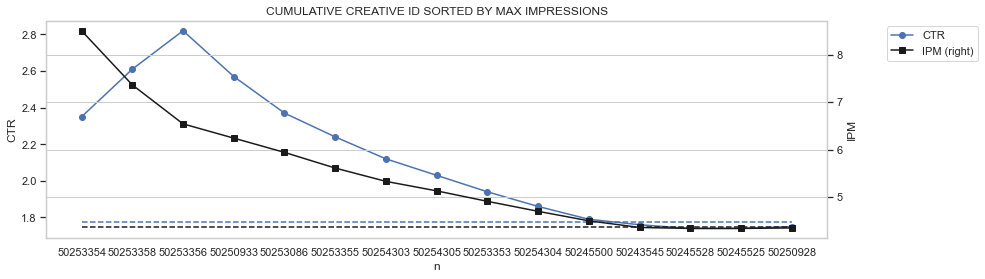

In [11]:
#plotting cumulative data

#creating new df
df, IPM_threshold, CVR_threshold, CTR_threshold = new_df(creative, 'impressions', 16)

#plot
ax = df.plot(x='n', y='CTR', marker='o',title = 'CUMULATIVE CREATIVE ID SORTED BY MAX IMPRESSIONS', color='b',figsize=(14, 4))
ax2 = df.plot(x='n', y='IPM',secondary_y=True, color='k', marker='s', ax=ax)
ax.set_ylabel('CTR')
ax2.set_ylabel('IPM')
plt.xticks(range(0,len(df.index)), df.n)
ax.get_legend().set_bbox_to_anchor((1.2, 1))

#ploting threshold 
ax2.plot([0, 14], [IPM_threshold, IPM_threshold], "k--")
ax.plot([0, 14], [CTR_threshold, CTR_threshold], "k--", color='b');

Since we're dealing with creatives here, we want to maximize CTR while maintaining tolerable IPM. We can see that cumulative CTR from _'50253354'_ to _'50253356'_ generates the highest CTR while still maintaining IPM way above the overall IPM.

**Target Creative Id: 50253354, 50253358, 50253356**

#### Looking at creative_id_2

In [12]:
%%sql
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    Datetime,
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
)

SELECT
imp.CREATIVE_ID_1,
imp.CREATIVE_ID_2,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1,2
ORDER BY 5 DESC
LIMIT 10;

 * sqlite:///kayzen.db
Done.


CREATIVE_ID_1,CREATIVE_ID_2,impressions,clicks,installs
50253354,50278809,70538,1888,703
50250933,50273395,19022,157,79
50253086,50276235,18848,148,68
50253358,50277854,5047,290,49
50253354,50277876,3230,93,28
50245528,50263632,5456,61,18
50253355,50277800,2622,51,15
50253356,50277855,1837,102,12
50253355,50277853,948,22,10
50253353,50277843,7643,37,9


Top perfoming, by far, CREATIVE_ID_2 in terms of installs is 50278809 which is under CREATIVE_ID_1 50253354

#### Targeting Criteria 1: OS Version

In [13]:
query="""
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    Datetime,
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
)
SELECT
--imp.DEVICE_OS,
imp.OS_Version,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1
ORDER BY 2, 4 DESC;
"""

os_ver = pd.read_sql_query(query,conn)
get_metrics(os_ver)

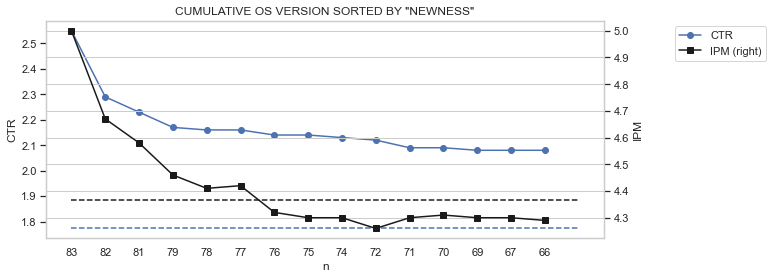

In [14]:
df, IPM_threshold, CVR_threshold, CTR_threshold = new_df(os_ver, 'OS_Version', 16)

#plot
ax = df.plot(x='n', y='CTR', marker='o',title = 'CUMULATIVE OS VERSION SORTED BY "NEWNESS"', color='b',figsize=(10, 4))
ax2 = df.plot(x='n', y='IPM',secondary_y=True, color='k', marker='s', ax=ax)
ax.set_ylabel('CTR')
ax2.set_ylabel('IPM')
plt.xticks(range(0,len(df.index)), df.n)
ax.get_legend().set_bbox_to_anchor((1.3, 1))

#ploting threshold 
ax2.plot([0, 15], [IPM_threshold, IPM_threshold], "k--")
ax.plot([0, 15], [CTR_threshold, CTR_threshold], "k--", color='b');

Assuming that newer OS version holds higher value, we should target OS version 8+ since were seeing great performance on 'newer versions'  but declining for the 'older versions'

**Target OS Version: [81, 82, 83]**

In [15]:
os_ver.sort_values(by=['OS_Version'])

,OS_Version,impressions,clicks,installs,CTR,CVR,IPM
21,0,175363,2811,775,1.602961,27.570260,4.419404
1,42,17,0,0,0.000000,NaN,0.000000
3,43,24,0,0,0.000000,NaN,0.000000
0,51,15,0,0,0.000000,NaN,0.000000
5,52,131,0,0,0.000000,NaN,0.000000
2,64,23,0,0,0.000000,NaN,0.000000
8,65,188,0,0,0.000000,NaN,0.000000
9,66,268,0,0,0.000000,NaN,0.000000
4,67,52,0,0,0.000000,NaN,0.000000
6,69,139,1,0,0.719424,0.000000,0.000000


#### Targeting Criteria 2:
* **_'DEVICE_MODEL'_** : [5090, 0, 896, 5693, 5741, 5735, 5692]
* **_'EXCHANGE_ID'_** : [10044, 23, 10049]
* **_'IMP_ORIENTATION'_** : ['portrait']
* **_'Category'_** : ['Games', 'Entertainment']

In [16]:
query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    Datetime,
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
),
    pubs AS (
    SELECT
    [App ID],
    [Category]
    FROM Categories
    )
SELECT
strftime('%m/%d/%Y',imp.Datetime) AS Date,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
LEFT JOIN pubs p ON p.[App ID] = imp.[App ID]
WHERE imp.EXCHANGE_ID in (10044, 23, 10049)
AND imp.DEVICE_MODEL in (5090, 0, 896, 5693, 5741, 5692)
AND imp.IMP_ORIENTATION = 'portrait'
AND p.[Category] in ('Games', 'Entertainment')
GROUP BY 1
;
"""

t_2 = pd.read_sql_query(query,conn)
get_metrics(t_2)

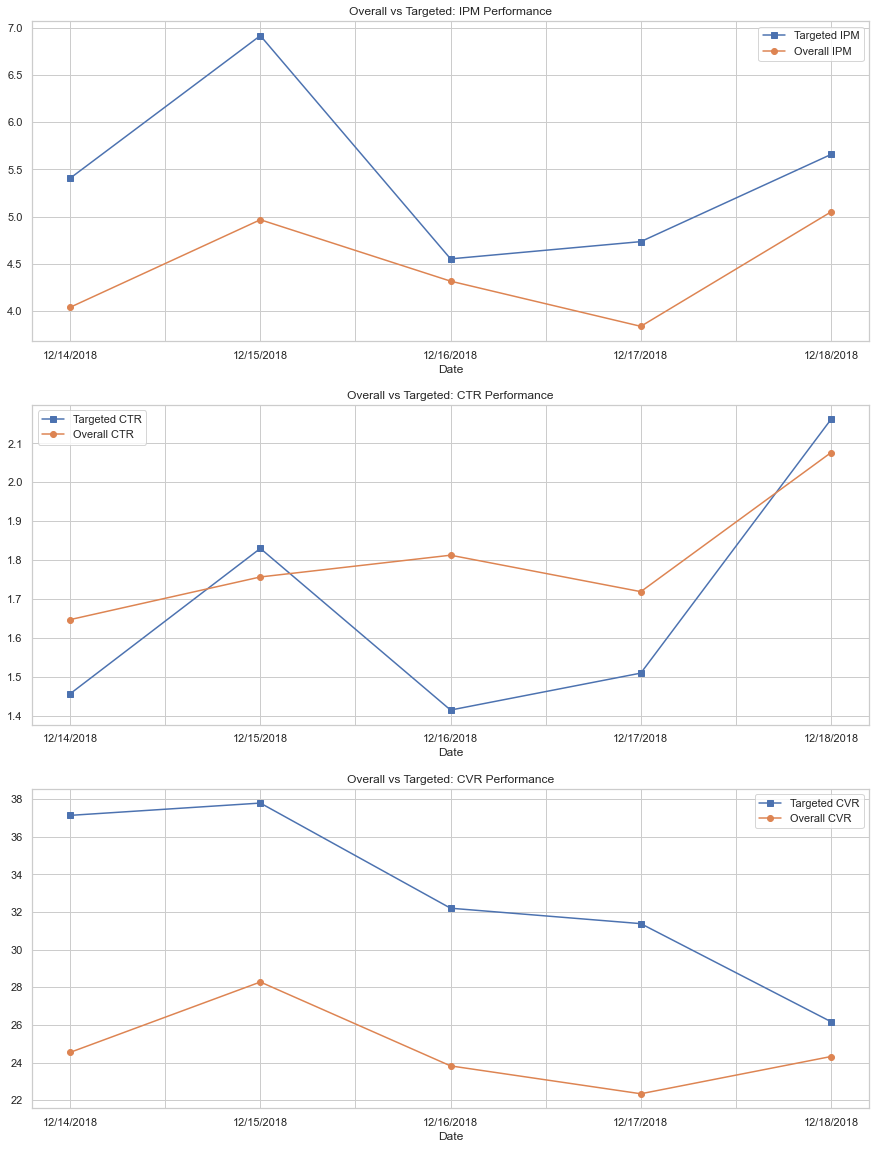

In [17]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,20))


ax = t_2.plot(x='Date', y='IPM', marker='s',title = 'Overall vs Targeted: IPM Performance',ax=axes[0])
ax2 = overall.plot(x='Date', y='IPM', ax=axes[0], marker='o')
ax.legend(["Targeted IPM", "Overall IPM"])


#CTR
ax = t_2.plot(x='Date', y='CTR', marker='s',title = 'Overall vs Targeted: CTR Performance',ax=axes[1])
ax2 = overall.plot(x='Date', y='CTR', ax=axes[1], marker='o')
ax.legend(["Targeted CTR", "Overall CTR"])


#CVR
ax = t_2.plot(x='Date', y='CVR', marker='s',title = 'Overall vs Targeted: CVR Performance',ax=axes[2])
ax2 = overall.plot(x='Date', y='CVR', ax=axes[2], marker='o')
ax.legend(["Targeted CVR", "Overall CVR"])


#### Targeting Criteria 2: Device Model

* Note: There is only one device model for _DEVICE_MANUFACTURER_ : 2

In [18]:
query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    Datetime,
    [Epoch Timestamp],
    DEVICE_OS
    FROM install
    WHERE can_claim = 1
)
SELECT
--i.DEVICE_OS,
--imp.DEVICE_MANUFACTURER,
imp.DEVICE_MODEL,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
WHERE imp.DEVICE_MANUFACTURER = 1317
GROUP BY 1
ORDER BY 4 DESC;
"""
d_model = pd.read_sql_query(query,conn)
get_metrics(d_model)

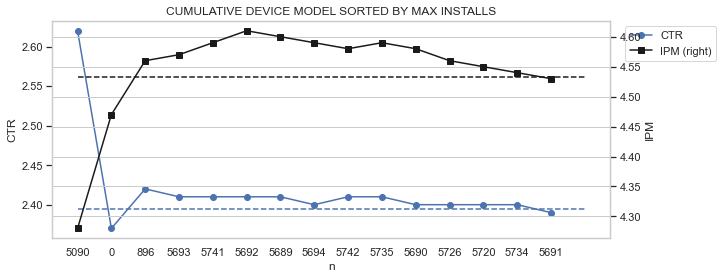

In [19]:
df, IPM_threshold, CVR_threshold, CTR_threshold = new_df(d_model, 'installs', 16)

#plot
ax = df.plot(x='n', y='CTR', marker='o',title = 'CUMULATIVE DEVICE MODEL SORTED BY MAX INSTALLS', color='b',figsize=(10, 4))
ax2 = df.plot(x='n', y='IPM',secondary_y=True, color='k', marker='s', ax=ax)
ax.set_ylabel('CTR')
ax2.set_ylabel('IPM')
plt.xticks(range(0,len(df.index)), df.n)
ax.get_legend().set_bbox_to_anchor((1.2, 1))

#ploting threshold 
ax2.plot([0, 15], [IPM_threshold, IPM_threshold], "k--")
ax.plot([0, 15], [CTR_threshold, CTR_threshold], "k--", color='b');

Since we only have one device model on device manufacturer _'2'_ which is _'0'_. We will isolate device manufacturer '1317' to better see the performance per device model.

Seeing the cumulative metrics ordered by max install delivered, starting from device model 5090, we hit peak IPM on 5692 while still delivering CTR above threshold.

**Target Device Model [5090, 0, 896, 5693, 5741, 5692]** <br/>
_note: this is applied to both manufacturers [2, 1317]_

#### Targeting Criteria 2: Impression Orientation

In [20]:
query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
    )
SELECT
imp.IMP_ORIENTATION,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1
ORDER BY 1;
"""
orient = pd.read_sql_query(query,conn)
get_metrics(orient)
orient

,IMP_ORIENTATION,impressions,clicks,installs,CTR,CVR,IPM
0,landscape,19404,91,2,0.468975,2.197802,0.103072
1,portrait,256651,4803,1203,1.871413,25.046846,4.687299


We're seeing a slightly higher click-through rate on landscape but in terms of install based metrics (CVR and IPM), it is being outperformed by portrait.

**Target imp orientation: Portrait**

#### Targeting Criteria 2: App Id (Category)

In [21]:
query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
    ),
    pubs AS (
    SELECT
    [App ID],
    [Category]
    FROM Categories
    )
SELECT
imp.[App Id] AS [App Id],
p.[Category],
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
LEFT JOIN pubs p ON p.[App ID] = imp.[App ID]
GROUP BY 1,2
ORDER BY 1;
"""
pub = pd.read_sql_query(query,conn)
get_metrics(pub)

In [22]:
pub.nlargest(10,'installs')

,App Id,Category,impressions,clicks,installs,CTR,CVR,IPM
1080,1320296369,Games,45294,716,418,1.580783,58.379888,9.228595
85,1047961826,Games,87870,838,358,0.953682,42.720764,4.074201
218,1093190533,Games,10806,212,162,1.961873,76.415094,14.991671
1604,1423608757,Games,11876,216,150,1.818794,69.444444,12.630515
1676,1435899684,Games,2950,322,66,10.915254,20.496894,22.372881
891,1277056784,Games,10698,86,64,0.803889,74.418605,5.982427
1483,1398987473,Games,6360,108,54,1.698113,50.000000,8.490566
1729,1438154014,Games,4824,102,54,2.114428,52.941176,11.194030
1286,1355694041,Games,4156,54,52,1.299326,96.296296,12.512031
1839,319881193,Social Networking,30500,376,52,1.232787,13.829787,1.704918


_note: categories are scraped from apple app store and google play. See Categories.ipynb_

We seem to be delivering good volume of installs from apps with the category **_'Games'_**

In [23]:
pub_cat = pd.pivot_table(pub, values=['impressions','clicks','installs'],
                index=['Category'], aggfunc=np.sum)
pub_cat.reset_index(inplace=True)
get_metrics(pub_cat)
pub_cat.sort_values(by='impressions', ascending=0).head(10)

,Category,clicks,impressions,installs,CTR,CVR,IPM
9,Games,6207,413774,2110,1.500094,33.993878,5.099402
24,Social Networking,1207,62547,92,1.929749,7.622204,1.470894
6,Entertainment,365,6095,35,5.988515,9.589041,5.742412
14,Music,37,2696,3,1.372404,8.108108,1.112760
18,Photo & Video,4,1066,0,0.375235,0.000000,0.000000
25,Sports,518,908,1,57.048458,0.193050,1.101322
28,Utilities,7,888,0,0.788288,0.000000,0.000000
29,Weather,9,869,0,1.035673,0.000000,0.000000
12,Lifestyle,5,700,0,0.714286,0.000000,0.000000
5,Education,2,319,0,0.626959,0.000000,0.000000


_note: categories are scraped from apple app store and google play. See Categories.ipynb_

Looking at computed metrics per publisher, both _'Games'_ and _'Entertainment'_ categories delivered good install to impression rate.

#### Targeting Criteria 2: Exchange Id

In [24]:
query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    Datetime,
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
)

SELECT
imp.EXCHANGE_ID,
COUNT(imp.[Epoch Timestamp]) AS impressions,
COUNT(c.[Epoch Timestamp]) AS clicks,
COUNT(i.[Epoch Timestamp]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1
ORDER BY 1,2,4 DESC;"""

exch = pd.read_sql_query(query,conn)
get_metrics(exch)
exch.nlargest(10,'installs')

,EXCHANGE_ID,impressions,clicks,installs,CTR,CVR,IPM
11,10044,169570,2119,730,1.249631,34.450212,4.305007
5,23,76383,2433,420,3.185264,17.262639,5.498606
16,10049,11721,272,53,2.320621,19.485294,4.521798
10,10038,3661,16,1,0.437039,6.250000,0.273149
13,10046,8735,19,1,0.217516,5.263158,0.114482
0,11,273,4,0,1.465201,0.000000,0.000000
1,12,963,3,0,0.311526,0.000000,0.000000
2,14,19,0,0,0.000000,NaN,0.000000
3,18,587,1,0,0.170358,0.000000,0.000000
4,20,20,0,0,0.000000,NaN,0.000000


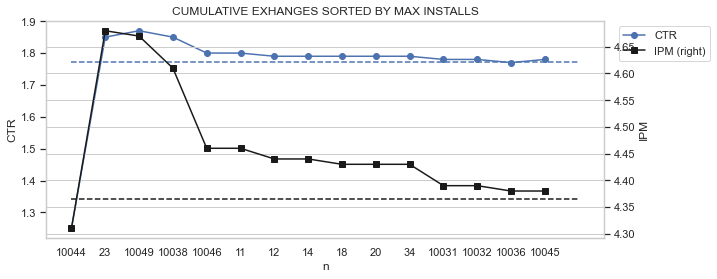

In [25]:
df, IPM_threshold, CVR_threshold, CTR_threshold = new_df(exch, 'installs', 16)

#plot
ax = df.plot(x='n', y='CTR', marker='o',title = 'CUMULATIVE EXHANGES SORTED BY MAX INSTALLS', color='b',figsize=(10, 4))
ax2 = df.plot(x='n', y='IPM',secondary_y=True, color='k', marker='s', ax=ax)
ax.set_ylabel('CTR')
ax2.set_ylabel('IPM')
plt.xticks(range(0,len(df.index)), df.n)
ax.get_legend().set_bbox_to_anchor((1.2, 1))

#ploting threshold 
ax2.plot([0, 15], [IPM_threshold, IPM_threshold], "k--")
ax.plot([0, 15], [CTR_threshold, CTR_threshold], "k--", color='b');

We're getting peak IPM on EXCHANGE_ID '10044' with significant no. of impressions and tolerable CTR and CVR

**Target Exchange Id [10044]** <br/>

### Other Features

#### Hour

In [26]:
query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    Datetime,
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
)

SELECT
strftime('%H',imp.Datetime) AS hour,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1
ORDER BY 1;
"""
hour = pd.read_sql_query(query,conn)
get_metrics(hour)

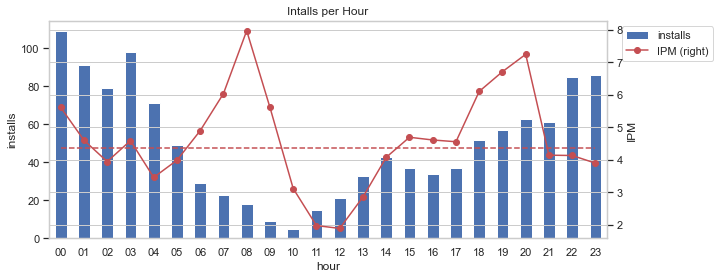

In [27]:
ax = hour.plot(x='hour', y='installs',kind='bar',title = 'Intalls per Hour',figsize=(10, 4))
ax2 = hour.plot(x='hour', y='IPM',secondary_y=True, ax=ax, color='r',marker='o')
ax.set_ylabel('installs')
ax2.set_ylabel('IPM')
ax.get_legend().set_bbox_to_anchor((1.2, 1))

IPM_threshold = (hour['installs'].sum()*1000)/hour['impressions'].sum()
ax2.plot([0, 23], [IPM_threshold, IPM_threshold], "k--", color='r');

We are seeing a huge dip in terms of IPM on hours 10-13. Ideally, if the campaigns are running for multiple countries, we want to run for the whole day.

#### Non-attributed installs (Hourly)

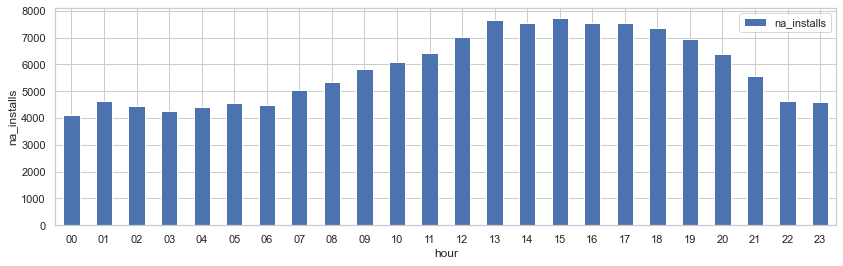

In [28]:
query="""
SELECT
strftime('%H',Datetime) AS hour,
COUNT([Raw User Id]) as na_installs
FROM install
WHERE can_claim = 0
GROUP BY 1
ORDER BY 1;"""

non_attr = pd.read_sql_query(query,conn)
ax = non_attr.plot(x='hour',y='na_installs',kind='bar',figsize=(14, 4), rot=0)
ax.set_ylabel('na_installs');

Looking at non-attributed installs, high install volume from hrs 9-20.

#### Wifi

In [29]:
query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
    )
SELECT
imp.IS_WIFI,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1
ORDER BY 1;
"""
wifi = pd.read_sql_query(query,conn)
get_metrics(wifi)
wifi

,IS_WIFI,impressions,clicks,installs,CTR,CVR,IPM
0,0,83964,1578,354,1.879377,22.43346,4.216093
1,1,192091,3316,851,1.726265,25.66345,4.430192


Install based metrics are delivering slightly higher values for Wifi Users.

**Target Wifi [1]**

#### Connection Type

In [30]:
query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
    )
SELECT
imp.CONNECTION_TYPE ,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1
ORDER BY 1;
"""
conn_type = pd.read_sql_query(query,conn)
get_metrics(conn_type)
conn_type

,CONNECTION_TYPE,impressions,clicks,installs,CTR,CVR,IPM
0,0,3744,28,2,0.747863,7.142857,0.534188
1,1,192091,3316,851,1.726265,25.663450,4.430192
2,2,80220,1550,352,1.932186,22.709677,4.387933


Assuming that Connection Type pertains to 'Internet Connection':
* Users with faster connections tend to convert more
* Users with slower connections tend not to convert since it takes time to get to the landing page or installing the app

**Type 1 and 2: Faster Connection speed**
* Overall metrics are better for both

**Target Connection Type: 1 and 2**

#### Country

In [31]:
query = """
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    country_code,
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
    ),
    countries AS (
    SELECT
    REQ_COUNTRY_ID,
    COUNTRY_NAME
    FROM country
    )

SELECT
imp.REQ_COUNTRY_ID,
cs.COUNTRY_NAME,
--i.country_code,
COUNT(imp.[Unique Id]) AS impressions,
COUNT(c.[Unique Id]) AS clicks,
COUNT(i.[Unique Id]) AS installs
FROM imp 
LEFT JOIN countries cs ON cs.REQ_COUNTRY_ID = imp.REQ_COUNTRY_ID
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1
ORDER BY 1;
"""
country = pd.read_sql_query(query,conn)
get_metrics(country)

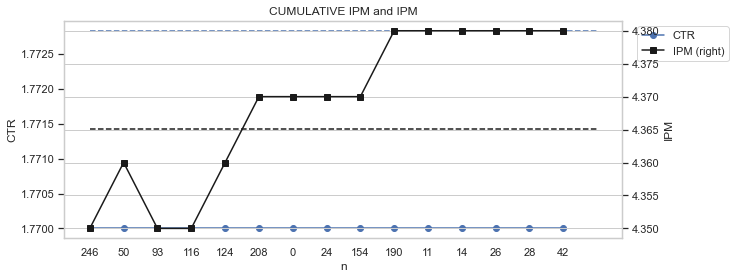

In [32]:
df, IPM_threshold, CVR_threshold, CTR_threshold = new_df(country, 'installs', 16)

#plot
ax = df.plot(x='n', y='CTR', marker='o',title = 'CUMULATIVE IPM and IPM', color='b',figsize=(10, 4))
ax2 = df.plot(x='n', y='IPM',secondary_y=True, color='k', marker='s', ax=ax)
ax.set_ylabel('CTR')
ax2.set_ylabel('IPM')
plt.xticks(range(0,len(df.index)), df.n)
ax.get_legend().set_bbox_to_anchor((1.2, 1))

#ploting threshold 
ax2.plot([0, 15], [IPM_threshold, IPM_threshold], "k--")
ax.plot([0, 15], [CTR_threshold, CTR_threshold], "k--", color='b');

In [33]:
world = gpd.read_file('Igismap/TM_WORLD_BORDERS-0.3.shp')
country_shapes = world[['name', 'geometry']]

#lookup values
lookup = country_shapes['name']
#fuzzywuzzy
def matching(x):
    highest = process.extractOne(x,lookup)
    return highest[0]

Text(0.5, 1.0, 'Overall installs per Country')

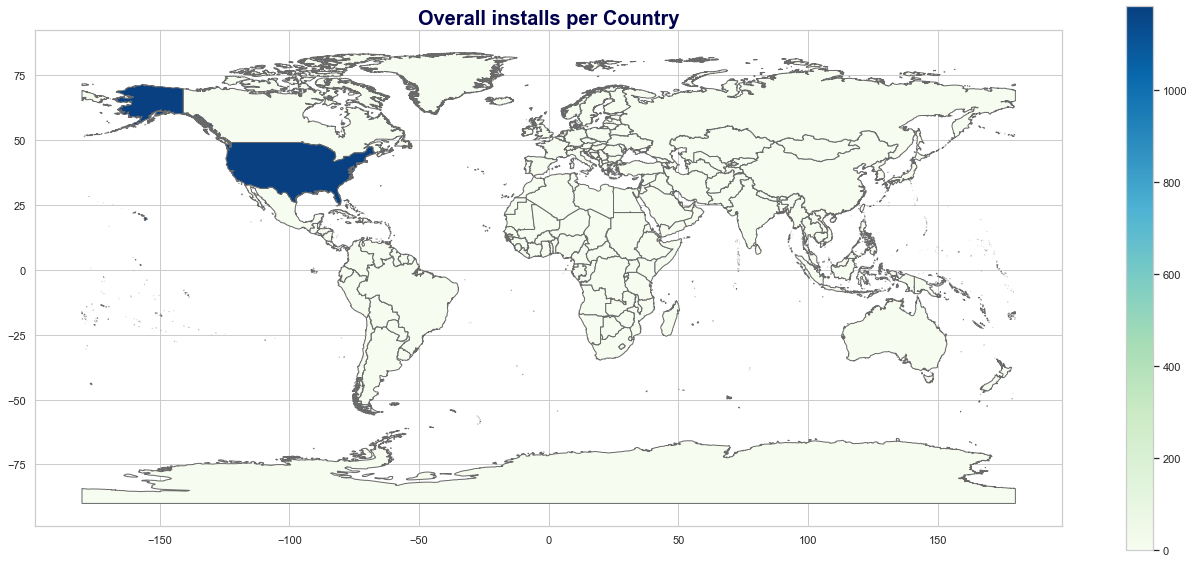

In [34]:

country = country[['COUNTRY_NAME','installs']]
#fixing US
country.replace('U.S.','United States', inplace=True)
#drop na
country.dropna(inplace=True)
#fuzzywuzzy
country['COUNTRY_NAME'] = country['COUNTRY_NAME'].map(matching)

#merge
country_count = country_shapes.merge(country[['COUNTRY_NAME','installs']], left_on='name', right_on='COUNTRY_NAME', how='left')
country_count = country_count.fillna(0)

# plot
fig = plt.figure(figsize=(23,10))
ax = fig.add_subplot(111)
country_count.plot(ax=ax, column='installs', cmap=plt.cm.GnBu, legend=True, edgecolor='dimgray') #cmap=plt.cm.Reds
ax.set_title('Overall installs per Country', fontsize=20, weight='bold',color='#00004d')

**Install Volume is coming mostly from US**

### Frequency

In [35]:
query="""
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    [Epoch Timestamp]
    FROM install
    WHERE can_claim = 1
    )
SELECT
imp.[Raw User Id] AS user_id,
strftime('%d',imp.Datetime) AS day,
COUNT(DISTINCT imp.[Unique Id]) AS imp,
COUNT(DISTINCT c.[Unique Id]) AS clk,
COUNT(DISTINCT i.[Unique Id]) AS install
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
GROUP BY 1,2;"""

per_user = pd.read_sql_query(query,conn)

In [36]:
# getting distinct user id: keeping max value
per_user = per_user.sort_values(by='imp', ascending=False)
per_user = per_user.drop_duplicates(subset='user_id', keep="first")

#group by frequency => max imp per user per day
freq_per_user = per_user.groupby(by=['imp']).agg(impressions=('user_id','count'),
                                                 clicks=('clk','sum'),
                                                 installs=('install','sum'))
get_metrics(freq_per_user)
freq_per_user.reset_index(inplace=True)
freq_per_user = freq_per_user.head(15)

freq_per_user.nlargest(10,'installs')

,imp,impressions,clicks,installs,CTR,CVR,IPM
0,1,85415,2084,773,2.439852,37.092131,9.049933
1,2,24012,791,207,3.294186,26.169406,8.620690
2,3,5820,227,54,3.900344,23.788546,9.278351
3,4,2049,102,25,4.978038,24.509804,12.201074
4,5,1041,72,18,6.916427,25.000000,17.291066
5,6,654,48,12,7.339450,25.000000,18.348624
6,7,458,50,6,10.917031,12.000000,13.100437
9,10,251,34,6,13.545817,17.647059,23.904382
8,9,289,28,5,9.688581,17.857143,17.301038
7,8,378,23,3,6.084656,13.043478,7.936508


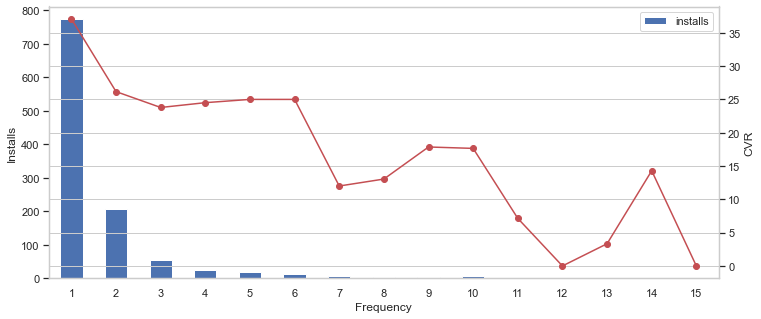

In [37]:
ax = freq_per_user.plot(x='imp', y='installs', kind='bar', figsize=(12,5))
ax2 = freq_per_user['CVR'].plot(secondary_y=True,ax=ax, marker='o',color='r')
ax.set_ylabel('Installs')
ax2.set_ylabel('CVR')
ax.set_xlabel('Frequency');

**Getting the max impression per user per day as our frequency, we can see that installation occurs for users who are only seeing the ad once per day.**

#### Avg Elapsed Time

In [38]:
query="""
WITH attr AS (
    SELECT
    [Unique Id],
    [Raw User Id],
    Datetime
    FROM install
    WHERE can_claim = 1
    ),
    dates_imp AS(
    SELECT
    [Raw User Id],
    imp.Datetime
    FROM imp
    )
SELECT
imp.[Raw User Id] AS user_id,
i.Datetime AS install_time,
MIN(d.Datetime) AS min_imp_time,
MAX(d.Datetime) AS max_imp_time,
COUNT(DISTINCT i.[Unique Id]) as install
FROM imp 
LEFT JOIN click c ON c.[Unique Id] = imp.[Unique Id]
LEFT JOIN attr i ON i.[Unique Id] = imp.[Unique Id]
LEFT JOIN dates_imp d ON d.[Raw User Id] = imp.[Raw User Id]
GROUP BY 1,2
HAVING install >= 1
ORDER BY 2
--LIMIT 10
;"""

time = pd.read_sql_query(query,conn)
time['elapsed'] = pd.to_datetime(time['install_time']) - pd.to_datetime(time['min_imp_time'])
# time['imp_elapsed'] = pd.to_datetime(time['max_imp_time']) - pd.to_datetime(time['min_imp_time'])
time['elapsed'].mean()

Timedelta('0 days 09:59:37.744398')

**Average elapsed time for the users who installed is ~10hrs from the moment after first seeing the ad.**